# Project on Stroke Prediction

## Machine Learning Workflow

Although the exact implementation details can vary, the general structure of a machine learning project stays relatively constant:

    1) Data cleaning and formatting
    2) Exploratory data analysis
    3) Feature engineering and selection
    4) Establish a baseline and compare several machine learning models on a performance metric
    5) Perform hyperparameter tuning on the best model to optimize it for the problem
    6) Evaluate the best model on the testing set
    7) Interpret the model results to the extent possible
    8) Draw conclusions and write a well-documented report

# Import
We will use the standard data science and machine learning libraries: numpy, pandas, and scikit-learn. We also use matplotlib and seaborn for visualization.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice, i.e. no annoying pink boxes
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Data Cleaning and Formatting

## Load in the Data and Examine

We will be loading our data into a pandas dataframe, one of the most useful data structures for data science. Think of it as a spreadsheet within Python that we can easily manipulate, clean, and visualize. [Pandas has many methods](http://pandas.pydata.org/pandas-docs/stable/) to help make the data science/machine learning pipeline as smooth as possible.

In [2]:
# Read in data into a dataframe 
train_df = pd.read_csv('train_2v.csv')
test_df = pd.read_csv('test_2v.csv')

# Because data is huge, for purpose of practice, will reduce it to 20% sample of the whole population for the time being.
train_df = train_df.sample(frac=0.6, replace=True)

# Display top of dataframe
train_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
26357,6484,Male,52.0,1,0,Yes,Private,Urban,93.58,26.1,never smoked,0
32965,44674,Female,33.0,0,0,Yes,Govt_job,Rural,93.82,19.7,never smoked,0
2662,53489,Male,11.0,0,0,No,children,Rural,73.28,17.2,never smoked,0
11748,53853,Female,51.0,0,0,Yes,Govt_job,Rural,128.15,25.5,NaN,0
37397,66704,Male,51.0,0,0,Yes,Private,Urban,79.36,32.4,formerly smoked,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 26357 to 23171
Data columns (total 12 columns):
id                   26040 non-null int64
gender               26040 non-null object
age                  26040 non-null float64
hypertension         26040 non-null int64
heart_disease        26040 non-null int64
ever_married         26040 non-null object
work_type            26040 non-null object
Residence_type       26040 non-null object
avg_glucose_level    26040 non-null float64
bmi                  25174 non-null float64
smoking_status       18190 non-null object
stroke               26040 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 2.6+ MB


Let's take a look to see if there are missing data in this dataframe set for Stroke

In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
missing_values_table(train_df)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
smoking_status,7850,30.1
bmi,866,3.3


# Exploratory Data Analysis

In [6]:
train_df_stroke = train_df.loc[train_df['stroke'] == 1]
sns.set(style="ticks")

In [7]:
numerical = [
  'age', 'bmi', 'avg_glucose_level'
]
categorical = [
  'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
]

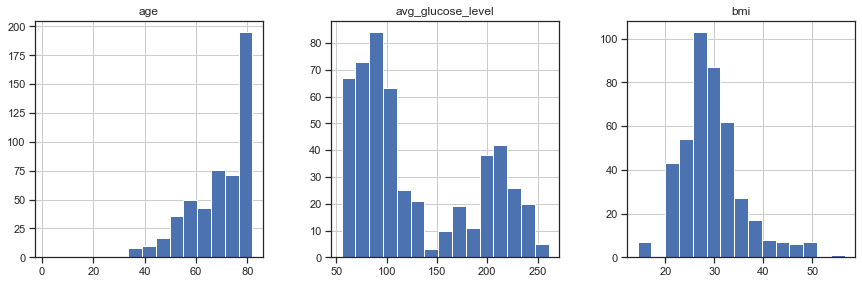

In [8]:
train_df_stroke[numerical].hist(bins=15, figsize=(20, 10), layout=(2, 4));

For the numerical data columns theres a few deductions can make by looking at the counts.
1. Chances of stroke is higher for people reaching the age of late 70s to their 80s.
2. Number of people with stroke is higher for those who seem to have average glucose level that is within the [permitted range](https://www.webmd.com/diabetes/qa/what-are-normal-blood-sugar-levels). 
3. Those whose BMI were at the higher end of 20s seem to be more susceptible to getting stroke.

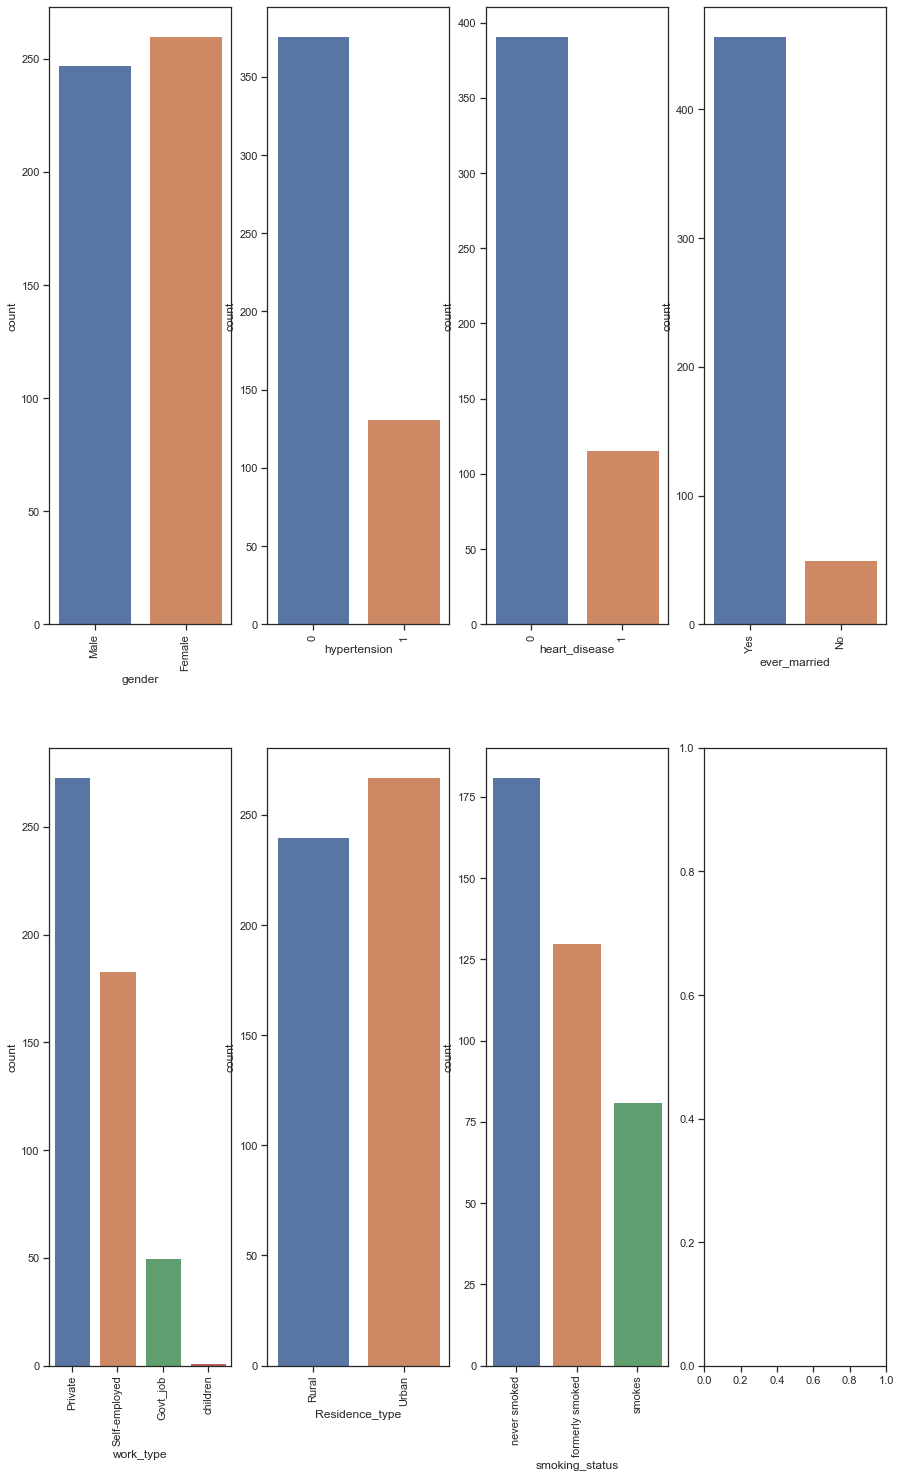

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(15, 25))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(train_df_stroke[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [10]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

In [11]:
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()


In [12]:
c_palette = ['tab:blue', 'tab:orange']

count    507.000000
mean      69.036134
std       11.830483
min        1.320000
25%       61.000000
50%       72.000000
75%       79.000000
max       82.000000
Name: age, dtype: float64
mode:  0    79.0
dtype: float64


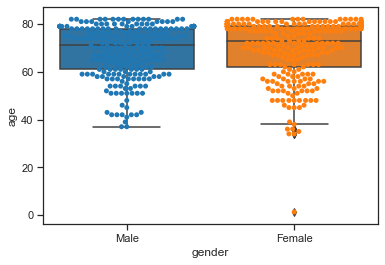

In [13]:
#Bivariate Analysis with target variable
quantitative_summarized(dataframe= train_df_stroke, y = 'age', x = 'gender', palette=c_palette, verbose=False, swarm=True)

From the data we can see that the average age of people who get stroke seem to be in their late 60s to 70s.

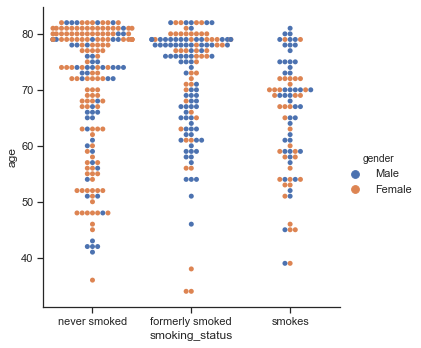

In [14]:
sns.catplot(x="smoking_status", y="age", hue="gender", kind="swarm", data=train_df_stroke);

count    507.000000
mean      69.036134
std       11.830483
min        1.320000
25%       61.000000
50%       72.000000
75%       79.000000
max       82.000000
Name: age, dtype: float64
mode:  0    79.0
dtype: float64


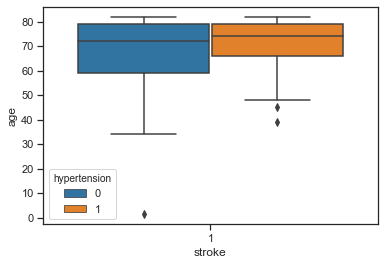

In [15]:
# multivariate analysis with Embarked variable and Pclass variable
quantitative_summarized(dataframe= train_df_stroke, y = 'age', x = 'stroke', hue = 'hypertension', palette=c_palette, verbose=False, swarm=False)


In [16]:
train_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
26357,6484,Male,52.0,1,0,Yes,Private,Urban,93.58,26.1,never smoked,0
32965,44674,Female,33.0,0,0,Yes,Govt_job,Rural,93.82,19.7,never smoked,0
2662,53489,Male,11.0,0,0,No,children,Rural,73.28,17.2,never smoked,0
11748,53853,Female,51.0,0,0,Yes,Govt_job,Rural,128.15,25.5,NaN,0
37397,66704,Male,51.0,0,0,Yes,Private,Urban,79.36,32.4,formerly smoked,0


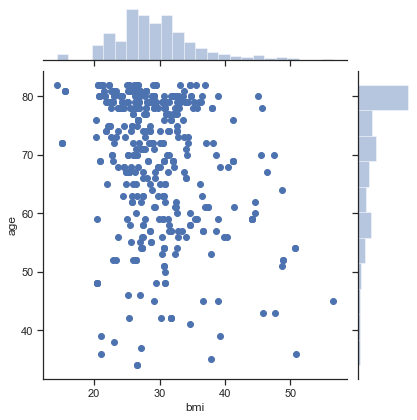

In [17]:
sns.jointplot(x=train_df_stroke['bmi'], y=train_df_stroke['age']);